# YouTube Data Collection and Cleaning
Data on YouTube videos from some of the top channels in the How-To category is collected and cleaned for later analysis and modeling

## Importing Libraries

In [10]:
from __future__ import print_function, division
import sys
import pickle

# Web Scraping
import requests
from bs4 import BeautifulSoup
import random
import time

# Numerical / Data
import pandas as pd
import numpy as np
import datetime as dt

# Plotting
import matplotlib.pyplot as plt
import seaborn as sns

# Sentiment Analysis
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

%matplotlib inline
# Python Version Check
print("Python Version:", sys.version, '\n')
requests.__path__
# make sure it lives in metis environment by printing the path

Python Version: 3.6.9 |Anaconda, Inc.| (default, Jul 30 2019, 13:42:17) 
[GCC 4.2.1 Compatible Clang 4.0.1 (tags/RELEASE_401/final)] 



['/anaconda3/envs/metis/lib/python3.6/site-packages/requests']

## Helper Functions
Define functions used later in the notebook

In [492]:
def str_to_bool(string):
    """
    returns 0 if the input is 'False' and 1 if the input is 'True'
    """
    if string == 'False':
        return 0
    elif string == 'True':
        return 1

## Gather Data

### List of trending YouTube Channels ("How-To Category")

Read in the dataset containing the top trending YouTube videos (source: https://www.kaggle.com/datasnaek/youtube-new)
Each row in the dataframe represents one video
All of the video ID's in this dataset can be constructed into a URL, which points to a channel's video, rather than the channel landing page itself

In [6]:
df = pd.read_csv('data/youtube_trending/us_youtube_trending.csv')

In [7]:
print('This dataset contains entries for {} videos'.format(df.shape[0]))

This dataset contains entries for 40949 videos


In [8]:
# Convert publish_date to a datetime object
df['format_publish_time'] = pd.to_datetime(df.publish_time,
                                           format='%Y-%m-%dT%H:%M:%S.%fZ')
df = df.drop('publish_time', axis=1)

In [16]:
# Convert trending date to datetime object
df['format_trending_date'] = pd.to_datetime(df.trending_date,
                                            format='%y.%d.%m')
df = df.drop('trending_date', axis=1)

In [18]:
# Drop columns that won't be used from this dataset
df = df.drop(['tags', 'thumbnail_link', 'description'], axis=1)

In [19]:
# Inspect the dataset
df.head()

,video_id,title,channel_title,category_id,views,likes,dislikes,comment_count,comments_disabled,ratings_disabled,video_error_or_removed,format_publish_time,format_trending_date
0,2kyS6SvSYSE,WE WANT TO TALK ABOUT OUR MARRIAGE,CaseyNeistat,22,748374,57527,2966,15954,False,False,False,2017-11-13 17:13:01,2017-11-14
1,1ZAPwfrtAFY,The Trump Presidency: Last Week Tonight with J...,LastWeekTonight,24,2418783,97185,6146,12703,False,False,False,2017-11-13 07:30:00,2017-11-14
2,5qpjK5DgCt4,"Racist Superman | Rudy Mancuso, King Bach & Le...",Rudy Mancuso,23,3191434,146033,5339,8181,False,False,False,2017-11-12 19:05:24,2017-11-14
3,puqaWrEC7tY,Nickelback Lyrics: Real or Fake?,Good Mythical Morning,24,343168,10172,666,2146,False,False,False,2017-11-13 11:00:04,2017-11-14
4,d380meD0W0M,I Dare You: GOING BALD!?,nigahiga,24,2095731,132235,1989,17518,False,False,False,2017-11-12 18:01:41,2017-11-14


In [72]:
# Inspect list of unique channel names in the "How-To" category
df[df.category_id == 26].channel_title.unique()

array(['Refinery29', 'JerryRigEverything', 'dope2111', 'John Lewis',
       'Amber Scholl', 'John Maclean', 'Bon Appétit', 'mayratouchofglam',
       'HowToBasic', 'clothesencounters', 'MsAaliyahJay', 'Dina Tokio',
       'Brothers Green Eats', 'Whitney Port', 'Christen Dominique',
       'CupcakeJemma', 'Zoella', 'Tati', 'JunsKitchen', 'Jackie Aina',
       'First We Feast', 'The Scran Line', 'Eater', 'You Suck At Cooking',
       'Pixielocks', 'INSIDER', 'Eric Strebel', 'Matthias Wandel',
       'Lauren Elizabeth', 'Rosanna Pansino', 'Tasty', 'BuzzFeed Nifty',
       'Maggie Lindemann', 'AlishaMarie', 'Fleur DeForce',
       'emmymadeinjapan', 'Kandee Johnson', 'MyLifeAsEva',
       'How To Cake It', 'ELLEUKTV', 'ELLE', 'ThreadBanger',
       'grav3yardgirl', 'AmazingPhil', 'Laura in the Kitchen',
       'Ingrid Nilsen', 'Bethany Mota', 'I Like To Make Stuff',
       'toofacedcosmetics', 'Epicurious', 'Grandpa Kitchen', 'Feelunique',
       'TiffyQuake', 'Chriselle Lim', 'POPSUGAR', 

### Get Channel URLS
Get a list of YouTube channel URLs in the How-To category for each unique channel

The first step is to get a URL that points to a video for each channel

Then go to each URL and use BeautifulSoup to scrape the channel's main URL from it. This function requires multiple conditional statements because YouTube video page HTML code is not formatted the same across all videos

In [299]:
# Filter out all videos outside of the category
howto_df = df[df.category_id == 26].copy()

# Narrow down df to only one row (one video) per unique channel
howto_df.drop_duplicates(subset='channel_title', inplace=True)


# Write a function to create url from video_id
def make_url(vid_id):
    return 'https://youtube.com/watch?v=' + vid_id


# Build list of video urls
vid_id_urls = list(
    zip(howto_df.channel_title, list(map(make_url, howto_df['video_id']))))


# Function to get channel url from video url
def get_channel_url(vid_url):
    """
    Returns a URL for a YouTube channel given a YouTube video URL
    """
    global count
    count += 1
    print(count)
    print(vid_url)
    # Scrape url
    headers = {
        'user-agent':
        'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_10_1) \
        AppleWebKit/537.36 (KHTML, like Gecko) \
        Chrome/41.0.2227.1 Safari/537.36'
    }
    response = requests.get(
        vid_url[1],
        headers=headers)  # [1] because input is tuple
    if response.status_code != 200:
        print("Check status code")
        return
    soup = BeautifulSoup(response.text, "lxml")
    if soup.find(text='This video is private.'):
        print("Video is private")
        return
    if len([
            x['content'] for x in soup.find_all('meta')
            if 'itemprop' in x.attrs.keys() and x['itemprop'] == 'channelId'
    ]) >= 1:
        meta_tags = soup.find_all('meta')
        channel_url = 'https://youtube.com/channel/' + [
            x['content'] for x in meta_tags
            if 'itemprop' in x.attrs.keys() and x['itemprop'] == 'channelId'
        ][0] + '/videos'  # and 'channelId' in x['itemprop']]
        print(channel_url)
        return channel_url
    elif len(
        [x['href']
         for x in soup.find_all('a') if '/channel/' in x['href']]) >= 1:
        a_tags = soup.find_all('a')
        channel_url = 'https://youtube.com' + [
            x['href'] for x in a_tags if '/channel/' in x['href']
        ][0] + '/videos'
        print(channel_url)
        return channel_url
    elif len(
        [x['href']
         for x in soup.find_all('link') if '/user/' in x['href']]) >= 1:
        link_tags = soup.find_all('link')
        channel_url = [x['href'] for x in link_tags if '/user/' in x['href']
                       ][0] + '/videos'
        print(channel_url)
        return channel_url
    print("something might be wrong")
    return

In [ ]:
# Generate list of channel urls
count = 0
channel_names = [vid_id_url[0] for vid_id_url in vid_id_urls]

# Zip together channel name and the link to the channel
channel_urls = list(
    zip(channel_names, [get_channel_url(vid_url) for vid_url in vid_id_urls]))

In [306]:
# Save channel URL list to access easily later
with open('data/channel_urls.pickle', 'wb') as to_write:
    pickle.dump(channel_urls, to_write)

In [657]:
# Drop channels that don't have an associated URL
channel_urls_dropnones = [x for x in channel_urls if x[1]]
len(channel_urls_dropnones)

181

In [662]:
# Drop channels that are duplicates
seen = set()
channel_urls_dropdups = [(ch_id, url) for ch_id, url in channel_urls_dropnones
                         if not (url in seen or seen.add(url))]

In [664]:
# Save cleaned channel URL list to access easily later
with open('data/channel_urls_dropdups.pickle', 'wb') as to_write:
    pickle.dump(channel_urls_dropdups, to_write)

## Scrape All Channels for Video Information

Define a function to retrieve the HTML code from a URL. Randomize the user-agent to minimize the likelihood of the request being denied. 

In [707]:
def get_soup(url):
    """
    This function parses a URL and returns the HTML code
    ---
    Input: URL (string)
    Output: HTML code (bs4.BeautifulSoup object)
    """
    UAS = (
        "Mozilla/5.0 (Windows NT 6.1; WOW64; rv:40.0) Gecko\
        /20100101 Firefox/40.1",
        "Mozilla/5.0 (Windows NT 6.3; rv:36.0) Gecko/20100101\
        Firefox/36.0",
        "Mozilla/5.0 (Macintosh; Intel Mac OS X 10_10; rv:33.0)\
        Gecko/20100101 Firefox/33.0",
        "Mozilla/5.0 (Windows NT 6.1) AppleWebKit/537.36\
        (KHTML, like Gecko) Chrome/41.0.2228.0 Safari/537.36",
        "Mozilla/5.0 (Macintosh; Intel Mac OS X 10_10_1) \
        AppleWebKit/537.36 (KHTML, like Gecko) Chrome/41.0.2227.1 \
        Safari/537.36",
        "Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKit/537.36 \
        (KHTML, like Gecko) Chrome/41.0.2227.0 Safari/537.36",
    )

    ua = UAS[np.random.randint(0, len(UAS))]

    headers = {'user-agent': ua}
    response = requests.get(url, headers=headers)
    print(response.status_code)
    if str(response.status_code)[0] != '2':
        print('Check status code = {}'.format(response.status_code))
        return
    soup = BeautifulSoup(response.text, 'lxml')
    return soup

## Get URLs for all videos
Write a function to scrape each YouTube channel page and obtain:
- List of video URLs for the user's 30 most recent videos 
- Duration of each video
- Name of each video

In [706]:
def get_vids_info_from_channel(channel_url):
    """
    Returns the URLs, names, durations for a channel's 30 most recent videos
    """
    print(channel_url)
    soup = get_soup(channel_url[1])
    channel = channel_url[0]
    a_tags = soup.find_all('a')
    vid_time_tags = soup.find_all(class_='video-time')
    vid_urls = [
        'https://www.youtube.com' + x['href'] for x in a_tags
        if 'aria-describedby' in x.attrs.keys()
    ]
    vid_names = [
        x['title'] for x in a_tags if 'aria-describedby' in x.attrs.keys()
    ]

    vid_times = []
    for tag in vid_time_tags:
        if len(tag.text) <= 5:
            vid_times.append(pd.to_timedelta('00:' + tag.text))
        else:
            vid_times.append(pd.to_timedelta(tag.text))

    return pd.DataFrame({
        'title': vid_names,
        'duration': vid_times,
        'channel': channel,
        'url': vid_urls
    })

In [562]:
# Sample input to above function
channel_urls[0]

('Refinery29', 'https://youtube.com/channel/UCsZsDjpf2Ppv_cT2K6_q2cw/videos')

In [ ]:
# Get video URLs, names, and durations for all YouTube channels

all_vids_df = pd.DataFrame()  # Instantiate dataframe

# Run the function for each channel to populate dataframe
for channel_url in channel_urls_dropdups:
    df = get_vids_info_from_channel(channel_url)
    all_vids_df = all_vids_df.append(df)

Drop any duplicate videos

In [671]:
all_vids_df = all_vids_df[~all_vids_df.duplicated(
    subset='url')]  # Get rid of duplicate videos

In [1113]:
all_vids_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5084 entries, 0 to 29
Data columns (total 4 columns):
title       5084 non-null object
duration    5084 non-null timedelta64[ns]
channel     5084 non-null object
url         5084 non-null object
dtypes: object(3), timedelta64[ns](1)
memory usage: 358.6+ KB


In [1112]:
all_vids_df.nunique()

title       5077
duration    1688
channel      174
url         5084
dtype: int64

All of the URLs are unique (Some titles are not unique because some channels have posted videos under the same name)

In [121]:
# Inspect the dataframe
all_vids_df.head()

,index,title,duration,channel,url
0,0,How Our Beauty Director Gets Ready For Her Wed...,00:04:09,Refinery29,https://www.youtube.com/watch?v=RgsDzcaK7qk
1,1,What's In Disney Star Skai Jackson's Bag | Spi...,00:07:34,Refinery29,https://www.youtube.com/watch?v=T8YLN3-ihn4
2,2,I Got Transformed Into Camila Mendes From Rive...,00:06:08,Refinery29,https://www.youtube.com/watch?v=Iy-ZPfa6c9s
3,3,BLACKPINK'S Nail Artist Gave Me 2 Inch Jelly N...,00:07:47,Refinery29,https://www.youtube.com/watch?v=vGCvt2k_2lM
4,4,The Truth About Isis Families In Iraq | Truth ...,00:07:14,Refinery29,https://www.youtube.com/watch?v=929GKskppiw


In [756]:
all_vids_df.shape

(5084, 4)

There are 5084 videos in the dataset

In [1114]:
# Save all_vids_df to access easily later
with open('data/all_vids_df.pickle', 'wb') as to_write:
    pickle.dump(all_vids_df, to_write)

### Obtain remaining video stats
The functions below search through the HTML code for a YouTube video page to find relevant statistics and metadata about the video

In [122]:
# Functions to get video stats


def get_vid_views(soup):
    """
    Given the html code for a video page,
    returns the View Count of the video
    """
    vid_views = int(
        soup.find(class_='watch-view-count').text.split()[0].replace(',', ''))
    return vid_views


def get_vid_age(soup):
    """
    Given the html code for a video page,
    returns the Age of the video
    """
    vid_age = dt.date.today() - dt.datetime.strptime(
        soup.find(itemprop='datePublished')['content'], '%Y-%m-%d').date()
    return vid_age


def get_vid_paid(soup):
    """
    Given the html code for a video page,
    returns whether the Channel paid to post the video
    """
    paid = str_to_bool(soup.find(itemprop='paid')['content'])
    return paid


def get_vid_unlisted(soup):
    """
    Given the html code for a video page,
    returns whether the Channel has set
    the video to be unlisted in search results
    """
    unlisted = str_to_bool(soup.find(itemprop='unlisted')['content'])
    return unlisted


def get_vid_isFamilyFriendly(soup):
    """
    Given the html code for a video page,
    returns whether the Channel has marked the
    content of the video as family friendly
    """
    family_friendly = str_to_bool(
        soup.find(itemprop='isFamilyFriendly')['content'])
    return family_friendly


def get_vid_tags(soup):
    """
    Given the html code for a video page,
    returns the number of tags/keywords
    that the Channel assigned to the video
    """
    tags = len(soup.find_all(property='og:video:tag'))
    return tags


def get_vid_likes(soup):
    """
    Given the html code for a video page,
    returns the number of Likes of the video
    """
    likes = int(('0' + [
        x.text for x in soup.find_all('button')
        if 'title' in x.attrs.keys() and x['title'] == 'I like this'
    ][0]).replace(',', ''))
    return likes


def get_vid_dislikes(soup):
    """
    Given the html code for a video page,
    returns the number of Dislikes of the video
    """
    dislikes = int(('0' + [
        x.text for x in soup.find_all('button')
        if 'title' in x.attrs.keys() and x['title'] == 'I dislike this'
    ][0]).replace(',', ''))
    return dislikes


Compile all of the above functions into a larger function. Given the video of the URL, the HTML code is retrieved and fed through each function to obtain the video information.



In [927]:
def get_vid_stats(vid_url):
    """
    Returns dataframe with the following stats:
    age(days), view count(int), paid(bool), unlisted(bool),
    family friendly(bool),number of tags(int), likes(int),
    dislikes(int) for a video
    ---
    input: video url (string)
    """
    print(vid_url)
    soup = get_soup(vid_url)

    age = get_vid_age(soup)
    views = get_vid_views(soup)
    paid = get_vid_paid(soup)
    unlisted = get_vid_unlisted(soup)
    family_friendly = get_vid_isFamilyFriendly(soup)
    tags = get_vid_tags(soup)
    likes = get_vid_likes(soup)
    dislikes = get_vid_dislikes(soup)

    return pd.Series({
        'age': age,
        'views': views,
        'paid': paid,
        'unlisted': unlisted,
        'family_friendly': family_friendly,
        'tags': tags,
        'likes': likes,
        'dislikes': dislikes
    })

### Test the function
Set up a test dataframe containing only videos from a single channel to test the above function

In [ ]:
# Set up a test dataframe
test_df = all_vids_df[all_vids_df.channel_name == 'Refinery29']

In [583]:
# Run the function
test_stats = test_df['video_url'].apply(get_vid_stats)

In [586]:
# Merge test_stats df with original test_df
test_df = test_df.merge(test_stats, left_index=True, right_index=True)

In [587]:
# Inspect the results
test_df

,video_name,duration,video_url,channel_name,age,views,paid,unlisted,family_friendly,tags,likes,dislikes
0,How Our Beauty Director Gets Ready For Her Wed...,00:04:09,https://www.youtube.com/watch?v=RgsDzcaK7qk,Refinery29,0 days,6966,0,0,1,32,204,112
1,What's In Disney Star Skai Jackson's Bag | Spi...,00:07:34,https://www.youtube.com/watch?v=T8YLN3-ihn4,Refinery29,1 days,32134,0,0,1,28,1532,59
2,I Got Transformed Into Camila Mendes From Rive...,00:06:08,https://www.youtube.com/watch?v=Iy-ZPfa6c9s,Refinery29,2 days,30372,0,0,1,23,706,25
3,BLACKPINK'S Nail Artist Gave Me 2 Inch Jelly N...,00:07:47,https://www.youtube.com/watch?v=vGCvt2k_2lM,Refinery29,3 days,105656,0,0,1,32,3586,68
4,The Truth About Isis Families In Iraq | Truth ...,00:07:14,https://www.youtube.com/watch?v=929GKskppiw,Refinery29,5 days,34486,0,0,1,28,2216,21
5,What's In Ciara's Bag | Spill It | Refinery29,00:05:23,https://www.youtube.com/watch?v=XbjkpThnAIE,Refinery29,8 days,46943,0,0,1,30,1464,171
6,I Got A Perm For The First Time | Hair Me Out ...,00:06:54,https://www.youtube.com/watch?v=ZNp21gX_93g,Refinery29,9 days,232702,0,0,1,29,4061,222
7,The Truth About Black Women In The Weed Indust...,00:08:13,https://www.youtube.com/watch?v=LrmasKy8iIg,Refinery29,12 days,11595,0,0,1,29,672,29
8,5 Days Of Holistic Chinese Medicine | Try Livi...,00:14:51,https://www.youtube.com/watch?v=Y-dtf9OpLkw,Refinery29,13 days,50579,0,0,1,24,1431,154
9,I Tried Wearing My Hair Naturally For A Month ...,00:05:43,https://www.youtube.com/watch?v=Bur5s4AnDds,Refinery29,14 days,35205,0,0,1,22,1289,83


In [720]:
# Create a dataframe to store video stats for all videos
# Scrape using sleep function
all_stats_sleep = pd.DataFrame()

In [ ]:
# Scrape all of the info for all of the videos
# This for loop has to be run several times -
# after iterating through some number of video URLs,
# the scraper will encounter an error.
# The for loop is written such that it will pick up from
# wherever it left off until it has run through all URLs

# Pick up wherever it last broke and go to the end
for url in all_vids_df['url'][all_stats_sleep.shape[0]:]:
    all_stats_sleep = all_stats_sleep.append(get_vid_stats(url),
                                             ignore_index=True)
    time.sleep(.6 + 2 * random.random())

In [1102]:
# Check if all videos ran through the function
all_stats_sleep.shape[0]

5084

In [1103]:
# Inspect the dataframe with all of the video information
# gathered from the video URLs
all_stats_sleep

,age,dislikes,family_friendly,likes,paid,tags,unlisted,views
0,0 days,118.0,1.0,211.0,0.0,32.0,0.0,8296.0
1,1 days,63.0,1.0,1610.0,0.0,28.0,0.0,33960.0
2,2 days,25.0,1.0,707.0,0.0,23.0,0.0,30642.0
3,3 days,68.0,1.0,3641.0,0.0,32.0,0.0,107631.0
4,5 days,21.0,1.0,2217.0,0.0,28.0,0.0,34518.0
...,...,...,...,...,...,...,...,...
5079,337 days,724.0,1.0,70223.0,0.0,18.0,0.0,1960420.0
5080,344 days,1762.0,1.0,85290.0,0.0,24.0,0.0,2877066.0
5081,358 days,1495.0,1.0,90436.0,0.0,25.0,0.0,3473699.0
5082,365 days,2449.0,1.0,87412.0,0.0,24.0,0.0,3965104.0


In [1104]:
# Save vid stats df to access easily later
with open('data/all_stats_sleep.pickle', 'wb') as to_write:
    pickle.dump(all_stats_sleep, to_write)

In [47]:
# Code to open dataframes
with open('data/all_stats_sleep.pickle', 'rb') as read_file:
    all_stats_sleep = pickle.load(read_file)

with open('data/all_vids_df.pickle', 'rb') as read_file:
    all_vids_df = pickle.load(read_file)

Now put it all together

In [50]:
# Prepare dataframe with video names/URLs/durations
# to merge with video stats dataframe
all_vids_df.reset_index(inplace=True)

# Merge the two DFs together
youtube_vid_df = all_vids_df.merge(test_stats_sleep,
                                   left_index=True,
                                   right_index=True)

In [52]:
# Inspect dataframe

# Check for null values
youtube_vid_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5084 entries, 0 to 5083
Data columns (total 13 columns):
index              5084 non-null int64
title              5084 non-null object
duration           5084 non-null timedelta64[ns]
channel            5084 non-null object
url                5084 non-null object
age                5084 non-null timedelta64[ns]
dislikes           5084 non-null float64
family_friendly    5084 non-null float64
likes              5084 non-null float64
paid               5084 non-null float64
tags               5084 non-null float64
unlisted           5084 non-null float64
views              5084 non-null float64
dtypes: float64(7), int64(1), object(3), timedelta64[ns](2)
memory usage: 516.5+ KB


In [53]:
# Confirm 5084 unique video URLs
youtube_vid_df.nunique()

index                30
title              5077
duration           1688
channel             174
url                5084
age                 777
dislikes           1415
family_friendly       2
likes              4490
paid                  1
tags                 62
unlisted              1
views              5042
dtype: int64

In [54]:
# Save df to access easily later
with open('data/youtube_vid_df.pickle', 'wb') as to_write:
    pickle.dump(youtube_vid_df, to_write)

## Clean and Create Analysis Columns

In [56]:
# Create copy of DataFrame for cleaning
youtube_vid_df_clean = youtube_vid_df.copy()
# Look at summary statistics for the DataFrame
youtube_vid_df_clean.describe()

,index,duration,age,dislikes,family_friendly,likes,paid,tags,unlisted,views
count,5084.000000,5084,5084,5084.000000,5084.000000,5.084000e+03,5084.0,5084.000000,5084.0,5.084000e+03
mean,14.288749,0 days 00:13:15.653619,173 days 23:06:28.040912,837.885130,0.999607,2.678315e+04,0.0,20.727773,0.0,8.087587e+05
std,8.612955,0 days 00:11:08.065974,236 days 07:36:58.880180,5167.798301,0.019832,7.147156e+04,0.0,11.640199,0.0,2.759453e+06
min,0.000000,0 days 00:00:06,0 days 00:00:00,0.000000,0.000000,0.000000e+00,0.0,0.000000,0.0,2.100000e+01
25%,7.000000,0 days 00:07:13,37 days 00:00:00,53.000000,1.000000,2.744000e+03,0.0,12.000000,0.0,7.096850e+04
50%,14.000000,0 days 00:11:48,96 days 00:00:00,138.000000,1.000000,7.343000e+03,0.0,20.000000,0.0,1.939890e+05
75%,22.000000,0 days 00:17:13,207 days 00:00:00,463.250000,1.000000,2.334825e+04,0.0,29.000000,0.0,6.423810e+05
max,29.000000,0 days 08:00:01,2887 days 00:00:00,260764.000000,1.000000,1.790663e+06,0.0,65.000000,0.0,1.027066e+08


In [57]:
# Drop unnecessary "index" column
youtube_vid_df_clean.drop(labels='index', axis=1, inplace=True)

### Disabled Likes/Dislikes
Some videos have likes and dislikes disabled. These are excluded from this analysis

In [58]:
# See how many videos have zero likes
youtube_vid_df_clean.likes.value_counts(sort=True)

0.0         23
5.0         18
2.0         16
1.0         15
4.0         13
            ..
4841.0       1
44487.0      1
202014.0     1
5237.0       1
672.0        1
Name: likes, Length: 4490, dtype: int64

In [59]:
# Drop videos with zero likes to account for videos
# with likes/dislikes disabled
youtube_vid_df_clean = youtube_vid_df_clean[youtube_vid_df_clean.likes != 0]
youtube_vid_df_clean.reset_index(inplace=True)
youtube_vid_df_clean.drop(labels='index', axis=1, inplace=True)

In [1282]:
youtube_vid_df_clean

,title,duration,channel,url,age,dislikes,family_friendly,likes,paid,tags,unlisted,views
0,How Our Beauty Director Gets Ready For Her Wed...,00:04:09,Refinery29,https://www.youtube.com/watch?v=RgsDzcaK7qk,0 days,118.0,1.0,211.0,0.0,32.0,0.0,8296.0
1,What's In Disney Star Skai Jackson's Bag | Spi...,00:07:34,Refinery29,https://www.youtube.com/watch?v=T8YLN3-ihn4,1 days,63.0,1.0,1610.0,0.0,28.0,0.0,33960.0
2,I Got Transformed Into Camila Mendes From Rive...,00:06:08,Refinery29,https://www.youtube.com/watch?v=Iy-ZPfa6c9s,2 days,25.0,1.0,707.0,0.0,23.0,0.0,30642.0
3,BLACKPINK'S Nail Artist Gave Me 2 Inch Jelly N...,00:07:47,Refinery29,https://www.youtube.com/watch?v=vGCvt2k_2lM,3 days,68.0,1.0,3641.0,0.0,32.0,0.0,107631.0
4,The Truth About Isis Families In Iraq | Truth ...,00:07:14,Refinery29,https://www.youtube.com/watch?v=929GKskppiw,5 days,21.0,1.0,2217.0,0.0,28.0,0.0,34518.0
...,...,...,...,...,...,...,...,...,...,...,...,...
5056,Mr Beans RC Armchair,00:10:34,colinfurze,https://www.youtube.com/watch?v=9ro0_lJSNLw,337 days,724.0,1.0,70223.0,0.0,18.0,0.0,1960420.0
5057,Gas Heated Umbrella - Because British Weather,00:10:54,colinfurze,https://www.youtube.com/watch?v=PWTPFm6eZzs,344 days,1762.0,1.0,85290.0,0.0,24.0,0.0,2877066.0
5058,TurboJet Powered Scooter-IT'S ALIVE,00:04:58,colinfurze,https://www.youtube.com/watch?v=83jH0sVCM9Q,358 days,1495.0,1.0,90436.0,0.0,25.0,0.0,3473699.0
5059,TurboJet Scooter Build #2-Oil/Fuel/Test Fire,00:11:11,colinfurze,https://www.youtube.com/watch?v=bcd3vg-5hDA,365 days,2449.0,1.0,87412.0,0.0,24.0,0.0,3965104.0


We are left with 5061 videos after eliminating videos with likes/dislikes disabled

### Previous videos' likes, dislikes, and views

In [61]:
# Create new column for previous like, dislike, view counts
# This is the number of likes/dislikes/views that the previous
# video posted by the Channel received.

# Initialize these as numeric columns
youtube_vid_df_clean['prev_likes'] = np.nan
youtube_vid_df_clean['prev_dislikes'] = np.nan
youtube_vid_df_clean['prev_views'] = np.nan

In [62]:
# Populate columns with values
for ix in range(0, len(youtube_vid_df_clean) - 1):
    if youtube_vid_df_clean.loc[ix, 'channel'] == youtube_vid_df_clean.loc[
            ix + 1, 'channel']:
        youtube_vid_df_clean.loc[ix, 'prev_likes'] = youtube_vid_df_clean.loc[
            ix + 1, 'likes']
        youtube_vid_df_clean.loc[
            ix, 'prev_dislikes'] = youtube_vid_df_clean.loc[ix + 1, 'dislikes']
        youtube_vid_df_clean.loc[ix, 'prev_views'] = youtube_vid_df_clean.loc[
            ix + 1, 'views']

In [98]:
# Repeat the above process except go back 10, 15, and 20
# videos prior from each Channel
youtube_vid_df_clean.prev10_views = np.nan
youtube_vid_df_clean.prev20_views = np.nan
youtube_vid_df_clean.prev15_views = np.nan

# Populate columns
for ix in range(0, len(youtube_vid_df_clean) - 10):
    if youtube_vid_df_clean.loc[ix, 'channel'] == youtube_vid_df_clean.loc[
            ix + 10, 'channel']:
        youtube_vid_df_clean.loc[
            ix, 'prev10_views'] = youtube_vid_df_clean.loc[ix + 10, 'views']

for ix in range(0, len(youtube_vid_df_clean) - 15):
    if youtube_vid_df_clean.loc[ix, 'channel'] == youtube_vid_df_clean.loc[
            ix + 15, 'channel']:
        youtube_vid_df_clean.loc[
            ix, 'prev15_views'] = youtube_vid_df_clean.loc[ix + 15, 'views']

for ix in range(0, len(youtube_vid_df_clean) - 20):
    if youtube_vid_df_clean.loc[ix, 'channel'] == youtube_vid_df_clean.loc[
            ix + 20, 'channel']:
        youtube_vid_df_clean.loc[
            ix, 'prev20_views'] = youtube_vid_df_clean.loc[ix + 20, 'views']

In [99]:
# Inspect the results
youtube_vid_df_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4887 entries, 0 to 4886
Data columns (total 21 columns):
title                4887 non-null object
duration             4887 non-null int64
channel              4887 non-null object
url                  4887 non-null object
age                  4887 non-null int64
dislikes             4887 non-null float64
family_friendly      4887 non-null float64
likes                4887 non-null float64
paid                 4887 non-null float64
tags                 4887 non-null float64
unlisted             4887 non-null float64
views                4887 non-null float64
prev_likes           4887 non-null float64
prev_dislikes        4887 non-null float64
prev_views           4887 non-null float64
prev10_views         3157 non-null float64
prev20_views         1462 non-null float64
duration_outliers    4887 non-null bool
age_outliers         4887 non-null bool
views_outliers       4887 non-null bool
prev15_views         2307 non-null float64
dtypes

There are 3157 videos with information from its Channel's video released 10 prior. (2307 videos with 15 prior information, and 1462 videos with 20 prior information)

### Clean Up Null Values in Previous Likes/Dislikes/Views

In [100]:
# Drop rows with null values for previous video likes/dislikes/views
# each represents the oldest video collected from each unique channel,
# no info on previous video stats
youtube_vid_df_clean.dropna(
    subset=['prev_likes', 'prev_dislikes', 'prev_views'], inplace=True)
youtube_vid_df_clean.reset_index(inplace=True)
youtube_vid_df_clean.drop(labels='index', axis=1, inplace=True)

### Format time object columns to integer quantities

In [ ]:
# Convert duration column timedelta objects to seconds (int)
youtube_vid_df_clean['duration'] = youtube_vid_df_clean['duration'].dt.seconds

In [69]:
# Convert age column timedelta objects to days (int)
# This is the number of days since the video was released
youtube_vid_df_clean['age'] = youtube_vid_df_clean['age'].dt.days

In [102]:
# Save df to access easily later
with open('data/youtube_vid_df_clean.pickle', 'wb') as to_write:
    pickle.dump(youtube_vid_df_clean, to_write)

In [103]:
# Code to open
with open('data/yt_df_copy.pickle', 'rb') as to_read:
    yt_df_copy = pickle.load(to_read)

### Find outliers in Video Age, Duration, and View Count

In [105]:
def findOutliers(df, column, lim_scalar=1.5):
    """
    Returns outliers above the max limit for a column in a dataframe
    Adjust outlier cutoff to q75 + 4*iqr to include more data
    ---
    input: DataFrame, column(series),lim_scalar(float)
    output: DataFrame
    """
    q25, q50, q75 = df[column].quantile(q=[0.25, 0.5, 0.75])
    iqr = q75 - q25
    # max limits to be considered an outlier
    max = q75 + lim_scalar * iqr
    # identify the points
    outlier_mask = [True if x > max else False for x in df[column]]
    print('{} outliers found out of {} data points, {}% of the data'.format(
        sum(outlier_mask), len(df[column]),
        100 * (sum(outlier_mask) / len(df[column]))))
    return outlier_mask

In [106]:
# Inspect numerical columns to identify potentially skewed columns
youtube_vid_df_clean.describe()

,duration,age,dislikes,family_friendly,likes,paid,tags,unlisted,views,prev_likes,prev_dislikes,prev_views,prev10_views,prev20_views,prev15_views
count,4887.000000,4887.000000,4887.000000,4887.000000,4.887000e+03,4887.0,4887.000000,4887.0,4.887000e+03,4.887000e+03,4887.000000,4.887000e+03,3.157000e+03,1.462000e+03,2.307000e+03
mean,800.290567,167.394721,853.242071,0.999591,2.698760e+04,0.0,20.741559,0.0,8.156009e+05,2.707612e+04,843.623491,8.063257e+05,8.731396e+05,8.736048e+05,8.906737e+05
std,674.255686,225.917553,5265.749883,0.020228,7.221390e+04,0.0,11.620505,0.0,2.802374e+06,6.922272e+04,5196.334454,2.388447e+06,2.490899e+06,2.574267e+06,2.616680e+06
min,6.000000,0.000000,0.000000,0.000000,1.000000e+00,0.0,0.000000,0.0,2.100000e+01,1.000000e+00,0.000000,3.200000e+01,3.600000e+01,7.000000e+01,3.600000e+01
25%,437.000000,36.000000,54.000000,1.000000,2.762000e+03,0.0,12.000000,0.0,7.182200e+04,2.815000e+03,56.000000,7.401900e+04,7.916100e+04,8.165950e+04,7.913800e+04
50%,711.000000,93.000000,139.000000,1.000000,7.405000e+03,0.0,20.000000,0.0,1.959810e+05,7.536000e+03,141.000000,1.998320e+05,2.104250e+05,2.146125e+05,2.146020e+05
75%,1039.000000,200.000000,465.500000,1.000000,2.348100e+04,0.0,29.000000,0.0,6.436255e+05,2.384050e+04,477.500000,6.581830e+05,7.173510e+05,7.276338e+05,7.246345e+05
max,28801.000000,2880.000000,260764.000000,1.000000,1.790663e+06,0.0,62.000000,0.0,1.027066e+08,1.790663e+06,260764.000000,6.813340e+07,6.813340e+07,6.813340e+07,6.813340e+07


The age column is particularly skewed - see the distribution in the box plot below

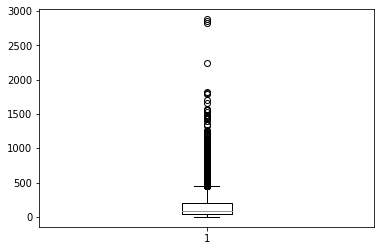

In [107]:
# Look at the distribution of the age column
plt.boxplot(youtube_vid_df_clean.age)

Find outliers

In [108]:
print('Duration: ')
youtube_vid_df_clean['duration_outliers'] = findOutliers(
    youtube_vid_df_clean, 'duration')
print('Age: ')
youtube_vid_df_clean['age_outliers'] = findOutliers(youtube_vid_df_clean,
                                                    'age')
print('Views: ')
youtube_vid_df_clean['views_outliers'] = findOutliers(youtube_vid_df_clean,
                                                      'views', 4)

Duration: 
157 outliers found out of 4887 data points, 3.212604870063433% of the data
Age: 
442 outliers found out of 4887 data points, 9.04440351954164% of the data
Views: 
275 outliers found out of 4887 data points, 5.627174135461428% of the data


In [109]:
# Remove duration outliers
clean_yt_df_duration = youtube_vid_df_clean.loc[
    ~youtube_vid_df_clean['duration_outliers']].drop(
        labels=['duration_outliers', 'age_outliers', 'views_outliers'], axis=1)

In [110]:
# Remove age outliers
clean_yt_df_age = youtube_vid_df_clean.loc[
    ~youtube_vid_df_clean['age_outliers']].drop(
        labels=['duration_outliers', 'age_outliers', 'views_outliers'], axis=1)

In [111]:
# Remove view count outliers
clean_yt_df_views = youtube_vid_df_clean.loc[
    ~youtube_vid_df_clean['views_outliers']].drop(
        labels=['duration_outliers', 'age_outliers', 'views_outliers'], axis=1)

In [112]:
# Merge the above dfs back together with all outliers removed
clean_yt_df = clean_yt_df_age.merge(clean_yt_df_duration,
                                    left_on=list(clean_yt_df_age.columns),
                                    right_on=list(
                                        clean_yt_df_duration.columns),
                                    how='inner')
clean_yt_df = clean_yt_df.merge(clean_yt_df_views,
                                left_on=list(clean_yt_df.columns),
                                right_on=list(clean_yt_df_views.columns),
                                how='inner')

### Add Video Title Information
These are additional features that will be considered in the linear regression models

In [113]:
# Create a column for the length of the video title
clean_yt_df['title_length'] = clean_yt_df.title.apply(str.split).apply(len)

In [114]:
# Create a column with the compound sentiment score for the title
analyzer = SentimentIntensityAnalyzer()

for ix, title in enumerate(clean_yt_df.title):
    vs = analyzer.polarity_scores(title)
    clean_yt_df.loc[ix, 'title_compound_score'] = vs['compound']

In [115]:
clean_yt_df.title_compound_score.describe()

count    4082.000000
mean        0.106614
std         0.321445
min        -0.886800
25%         0.000000
50%         0.000000
75%         0.323700
max         0.943200
Name: title_compound_score, dtype: float64

In [116]:
# Save df to access easily later
with open('data/clean_yt_df.pickle', 'wb') as to_write:
    pickle.dump(clean_yt_df, to_write)

In [117]:
# Code to open
with open('data/clean_yt_df.pickle', 'rb') as to_read:
    clean_yt_df = pickle.load(to_read)

In [118]:
# Create smaller dataframe with videos that have info
# from the Channel's 10th prior video
prev10_df = clean_yt_df.copy()
prev10_df.dropna(subset=['prev10_views'], inplace=True)
with open('data/prev10_df.pickle', 'wb') as to_write:
    pickle.dump(prev10_df, to_write)

## Conclusion

This dataframe is now ready for Exploratory Data Analysis and Linear Regression modeling, found in the next notebook "p02_EDA_and_Modeling"